<a href="https://colab.research.google.com/github/julianovale/MCDA/blob/main/0011_Trabalho_INSID_PrometheeII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# Ver isso: https://towardsdatascience.com/how-to-compute-satellite-image-statistics-and-use-it-in-pandas-81864a489144

In [1]:
# Filename: PROMETHEE_Preference_Functions.py
# Description: This module calculates the
# unicriterion preference degrees of the actions
# for a specific criterion
# Authors: Papathanasiou, J. & Ploskas, N.

from numpy import *

# Calculate the unicriterion preference degrees
def uni_cal(x, p, c, f):
    """ x is the action performances array, p is the
    array with the preference parameters of all 
	criteria, c is the criteria min (0) or max (1) 
	optimization array, and f is the preference 
	function array for a specific criterion ('u' 
	for usual, 'us' for u-shape, 'vs' for v-shape, 
	'le' for level, 'li' for linear, and 'g' for 
	Gaussian)
    """
    uni = zeros((x.shape[0], x.shape[0]))
    for i in range(size(uni, 0)):
        for j in range(size(uni, 1)):
            if i == j:
                uni[i, j] = 0
            elif f == 'u':  # Usual preference function
                if x[j] - x[i] > 0:
                    uni[i, j] = 1
                else:
                    uni[i, j] = 0
            elif f == 'us': # U-shape preference function
                if x[j] - x[i] > x[0]:
                    uni[i, j] = 1
                elif x[j] - x[i] <= p[0]:
                    uni[i, j] = 0
            elif f == 'vs': # V-shape preference function
                if x[j] - x[i] > p[1]:
                    uni[i, j] = 1
                elif x[j] - x[i] <= 0:
                    uni[i, j] = 0
                else:
                    uni[i, j] = (x[j] - x[i]) / p[1]
            elif f == 'le': # Level preference function
                if x[j] - x[i] > p[1]:
                    uni[i, j] = 1
                elif x[j] - x[i] <= p[0]:
                    uni[i, j] = 0
                else:
                    uni[i, j] = 0.5
            elif f == 'li': # Linear preference function
                if x[j] - x[i] > p[1]:
                    uni[i, j] = 1
                elif x[j] - x[i] <= p[0]:
                    uni[i, j] = 0
                else:
                    uni[i, j] = ((x[j] - x[i]) -
                        p[0]) / (p[1] - p[0])
            elif f == 'g':  # Gaussian preference function
                if x[j] - x[i] > 0:
                    uni[i, j] = 1 - math.exp(-(math.pow(x[j]
                        - x[i], 2) / (2 * p[1] ** 2)))
                else:
                    uni[i, j] = 0
    if c == 0:
        uni = uni
    elif c == 1:
        uni = uni.T
    # positive, negative and net flows
    pos_flows = sum(uni, 1) / (uni.shape[0] - 1)
    neg_flows = sum(uni, 0) / (uni.shape[0] - 1)
    net_flows = pos_flows - neg_flows
    return net_flows

In [2]:
# Filename: PROMETHEE_Final_Rank_Figure.py
# Description: Optional module to plot the
# results of PROMETHEE method
# Authors: Papathanasiou, J. & Ploskas, N.

import matplotlib.pyplot as plt
from graphviz import Digraph
from numpy import *

# Plot final rank figure
def graph(flows, b):
    """ flows is the matrix with the net flows, and b
    is a string describing the net flow
    """
    s = Digraph('Actions', node_attr = {'shape':
        'plaintext'})
    s.body.extend(['rankdir = LR'])
    x = sort(flows)
    y = argsort(flows)
    l = []
    for i in y:
        s.node('action' + str(i), '''<
        <TABLE BORDER="0" CELLBORDER="1"
            CELLSPACING="0" CELLPADDING="4">
          <TR>
            <TD COLSPAN="2" bgcolor="grey" >Action
                ''' + str(y[i] + 1) + '''</TD>
          </TR>
          <TR>
            <TD>'''+ b +'''</TD>
            <TD>''' + str(x[i]) + '''</TD>
          </TR>
        </TABLE>>''')
    k = []
    for q in range(len(flows) - 1):
        k.append(['action' + str(q + 1), 'action'
            + str(q)])
    print(k)
    s.edges(k)
    s.view()

# Plot final rank
def plot(a, b):
    """ a is the matrix with the net flows, and b
    is a string describing the method
    """
    flows = a
    yaxes_list = [0.2] * size(flows, 0)
    plt.plot(yaxes_list, flows, 'ro')
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    plt.axis([0, 0.7, min(flows) - 0.05,
        max(flows) + 0.05])
    plt.title(b + " results")
    plt.ylabel("Flows")
    plt.legend()
    plt.grid(True)
    z1 = []
    for i in range(size(flows, 0)):
        z1.append('   (Action ' + str(i + 1) + ')')
    z = [str(a) + b for a, b in zip(flows, z1)]
    for X, Y, Z in zip(yaxes_list, flows, z):
        plt.annotate('{}'.format(Z), xy = (X, Y),
            xytext=(10, -4), ha = 'left',
            textcoords = 'offset points')
    plt.show()

In [5]:
# Filename: PROMETHEE_II.py
# Description: PROMETHEE II method
# Authors: Papathanasiou, J. & Ploskas, N.

# PROMETHEE method: it calls the other functions
def promethee(x, p, c, d, w):
    """ x is the action performances array, b is the
    array with the preference parameters of all 
	criteria, c is the criteria min (0) or max (1) 
	optimization array, d is the preference 
	function array ('u' for usual, 'us' for 
	u-shape, 'vs' for v-shape, 'le' for level, 
	'li' for linear, and 'g' for Gaussian), and w
    is the weights array
    """
    weighted_uni_net_flows = []
    total_net_flows = []
    for i in range(x.shape[1]):
        weighted_uni_net_flows.append(w[i] *
            uni_cal(x[:, i:i + 1], p[:,
            i:i + 1], c[i], d[i]))
	
    # print the weighted unicriterion preference
    # net flows
    for i in range(size(weighted_uni_net_flows, 1)):
        k = 0
        for j in range(size(weighted_uni_net_flows, 0)):
            k = k + round(weighted_uni_net_flows[j][i], 5)
        total_net_flows.append(k)
    return around(total_net_flows, decimals = 4)

# main function
def main(a, b):
    """ a and b are flags; if they are set to 'y' they do
    print the results, anything else does not print
    the results
	"""

    # action performances array
    xi = [[8, 7, 2, 1], [5, 3, 7, 5], [7, 5, 6, 4], [9, 9, 7, 3], [11, 10, 3, 7], [6, 9, 5, 4]]
    x = array(xi)

    # preference parameters of all criteria array
    p = array([[1, 1, 1, 1], [2, 2, 2, 2]])

    # criteria min (0) or max (1) optimization array
    c = ([1, 1, 1, 1])

    # preference function array
    d = (['li', 'li', 'li', 'li'])

    # weights of criteria
    w = array([0.4, 0.3, 0.1, 0.2])

    # final results
    final_net_flows = promethee(x, p, c, d, w)
    print("Global preference flows = ", final_net_flows)
    if a == 'y':
        graph(final_net_flows, "Phi")
    if b == 'y':
        plot(final_net_flows, "PROMETHEE II")
    return final_net_flows

# if __name__ == '__main__':
#    main('n','y')

Global preference flows =  [-0.26 -0.52 -0.22  0.36  0.7  -0.06]
[['action1', 'action0'], ['action2', 'action1'], ['action3', 'action2'], ['action4', 'action3'], ['action5', 'action4']]


No handles with labels found to put in legend.


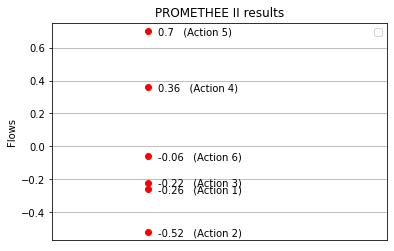

In [9]:
bubu = main('y', 'y')

In [7]:
bubu

array([-0.26, -0.52, -0.22,  0.36,  0.7 , -0.06])

In [16]:
! pip install geopandas

In [11]:
import geopandas as gpd
import matplotlib.pyplot as plt

In [14]:
! rm *.*

In [15]:
! wget https://github.com/julianovale/MCDA/raw/main/INSID/DadosPromethee.zip
! unzip DadosPromethee.zip
! wget https://github.com/julianovale/MCDA/raw/main/INSID/Logradouros.zip
! unzip Logradouros.zip
! ls

--2021-07-01 04:03:38--  https://github.com/julianovale/MCDA/raw/main/INSID/DadosPromethee.zip
Resolving github.com (github.com)... 52.192.72.89
Connecting to github.com (github.com)|52.192.72.89|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/julianovale/MCDA/main/INSID/DadosPromethee.zip [following]
--2021-07-01 04:03:39--  https://raw.githubusercontent.com/julianovale/MCDA/main/INSID/DadosPromethee.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29200 (29K) [application/zip]
Saving to: ‘DadosPromethee.zip’

DadosPromethee.zip  100%[===================>]  28.52K  --.-KB/s    in 0.003s  

2021-07-01 04:03:39 (9.28 MB/s) - ‘DadosPromethee.zip’ saved [29200/29200]

Archive:  DadosPromethee.z

In [18]:
setores = gpd.read_file('DadosPromethee.shp')
setores.head()

,ID,CD_GEOCODI,AREA_KM2,Rank,NDVI,Dens_Dem_H,Renda,Infra,%Alfabetiz,geometry
0,88939.0,352670405000001,0.16547,9,-0.81,0.64,0.76,0.57,0.98,"POLYGON ((-47.38783 -22.18287, -47.38729 -22.1..."
1,88940.0,352670405000002,0.23188,22,-0.78,0.74,0.97,-0.18,0.95,"POLYGON ((-47.38756 -22.18164, -47.38668 -22.1..."
2,88941.0,352670405000003,0.18694,27,-0.26,0.34,0.81,0.57,0.12,"POLYGON ((-47.38244 -22.18438, -47.38201 -22.1..."
3,88942.0,352670405000004,0.11315,25,-0.38,0.12,0.59,0.57,0.57,"POLYGON ((-47.38602 -22.18627, -47.38573 -22.1..."
4,88943.0,352670405000005,0.07081,40,-0.64,-0.29,0.90,-0.18,0.78,"POLYGON ((-47.38846 -22.19355, -47.38716 -22.1..."


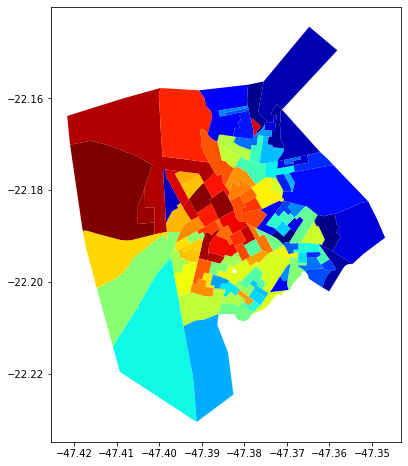

In [31]:
setores.plot(cmap = 'jet', column ='Renda', figsize = (8,8)) # colorido por região administrativa

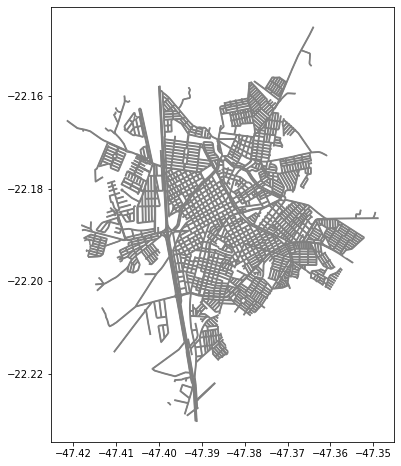

In [32]:
logradouros = gpd.read_file('Logradouros.shp')
logradouros.drop([7778], inplace=True)
logradouros.plot(color='grey', figsize = (8,8))

In [23]:
logradouros

,fid,CD_SETOR,CD_QUADRA,CD_FACE,NM_TIP_LOG,NM_TIT_LOG,NM_LOG,TOT_RES,TOT_GERAL,geometry
0,1.0,352670405000001,001,001,RUA,CORONEL,AUGUSTO CESAR,0.0,0.0,"LINESTRING (-47.39022 -22.18462, -47.39097 -22..."
1,2.0,352670405000001,001,002,RUA,None,BERNARDINO DE CAMPOS,4.0,7.0,"LINESTRING (-47.38980 -22.18531, -47.39022 -22..."
2,3.0,352670405000001,001,003,RUA,None,RAFAEL DE BARROS,0.0,1.0,"LINESTRING (-47.39060 -22.18573, -47.38980 -22..."
3,4.0,352670405000001,001,004,RUA,GENERAL,OSORIO,3.0,4.0,"LINESTRING (-47.39097 -22.18509, -47.39060 -22..."
4,5.0,352670405000001,002,001,RUA,CORONEL,AUGUSTO CESAR,6.0,9.0,"LINESTRING (-47.38940 -22.18410, -47.39015 -22..."
...,...,...,...,...,...,...,...,...,...,...
7774,7775.0,352670405000200,020,001,RUA,None,ERNESTO RAUTER,2.0,5.0,"LINESTRING (-47.36015 -22.19082, -47.36100 -22..."
7775,7776.0,352670405000200,020,002,RUA,None,JOSIMAR DANIEL STEFANO,2.0,3.0,"LINESTRING (-47.36058 -22.19139, -47.36042 -22..."
7776,7777.0,352670405000200,020,003,RUA,None,JOSE VICENTIN,5.0,7.0,"LINESTRING (-47.36107 -22.19044, -47.36058 -22..."
7777,7778.0,352670405000200,021,003,RUA,None,JOSIMAR DANIEL STEFANO,0.0,2.0,"LINESTRING (-47.36010 -22.19075, -47.35985 -22..."


In [28]:
logradouros.drop([7778], inplace=True)

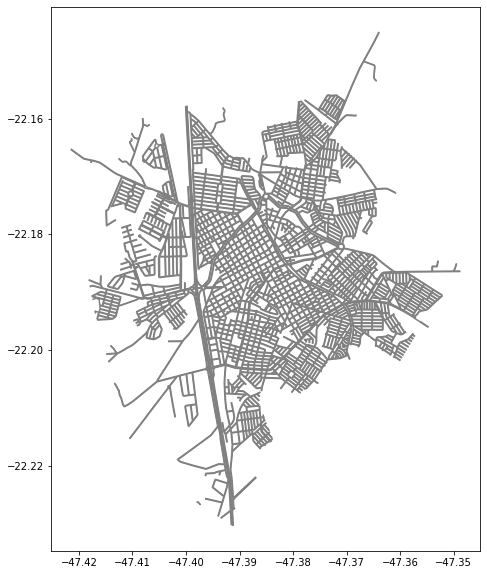

In [29]:

logradouros.plot(color='grey', figsize = (10,10))

In [ ]:
f, ax = plt.subplots(figsize = (20,20))
municipios.plot(ax=ax, cmap = 'Pastel1', column ='GID_RG') # colorido por região administrativa
municipios.boundary.plot(ax=ax, color='grey', linewidth=0.5)
ferrovias.plot(ax=ax, color='red')
estacoes.plot(ax=ax, marker='o', markersize=20, color='black')
plt.show()